In [1]:
#load the data by installing gdown
import os.path as path
if not path.exists('food-com-recipes-and-user-interactions.zip'):
  !pip install gdown
  !gdown https://drive.google.com/uc?id=1CK99ASX3fsQ_KBY_RP7Nqms6dwsNs-jb
  !unzip food-com-recipes-and-user-interactions.zip
else :
  print('data is in places')

Downloading...
From: https://drive.google.com/uc?id=1CK99ASX3fsQ_KBY_RP7Nqms6dwsNs-jb
To: /content/food-com-recipes-and-user-interactions.zip
275MB [00:02, 121MB/s]
Archive:  food-com-recipes-and-user-interactions.zip
  inflating: ingr_map.pkl            
  inflating: __MACOSX/._ingr_map.pkl  
  inflating: interactions_test.csv   
  inflating: __MACOSX/._interactions_test.csv  
  inflating: interactions_train.csv  
  inflating: __MACOSX/._interactions_train.csv  
  inflating: interactions_validation.csv  
  inflating: __MACOSX/._interactions_validation.csv  
  inflating: new_data.csv            
  inflating: __MACOSX/._new_data.csv  
  inflating: PP_recipes.csv          
  inflating: __MACOSX/._PP_recipes.csv  
  inflating: PP_users.csv            
  inflating: __MACOSX/._PP_users.csv  
  inflating: RAW_interactions.csv    
  inflating: __MACOSX/._RAW_interactions.csv  
  inflating: RAW_recipes.csv         
  inflating: __MACOSX/._RAW_recipes.csv  


In [0]:
#Load packages 
import pandas as pd
import numpy as np
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
from collections import Counter
from datetime import datetime
from datetime import timedelta
import community
import itertools

In [3]:
#import the data and inspect it
df_in = pd.read_csv('RAW_interactions.csv')
df_in.head()

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."


In [0]:
#change rating to decimal
df_in['w'] = df_in.apply(lambda x: 0 if x['rating'] == 0 else x['rating'] / 5, axis=1)

In [5]:
#change date to datetime
df_in['date'] = pd.to_datetime(df_in['date'], errors = 'coerce')
#filter the df from mid of 2018 until now to be more "notebook-friendly" as the original one is too big (more than 1 million rows)
start_date = '06-01-2018'
date_filter = (df_in['date'] > start_date)
df_int = df_in.loc[date_filter]
df_int.head()

,user_id,recipe_id,date,rating,review,w
200,2000551249,195977,2018-07-11,5,We have substituted a lemon cake mix for the y...,1.0
201,2002265401,195977,2018-09-03,2,I will start by saying that I followed the rec...,0.4
202,2001205226,195977,2018-11-03,5,This is an exceptionally tasty cake! Very swee...,1.0
250,615758,373842,2018-06-24,5,Made this for dinner last night and had it for...,1.0
276,246482,217012,2018-07-04,4,Very nice I got 18 muffins out of it but I thi...,0.8


In [6]:
#Do the same with the other dataframe "recipe"
df_re = pd.read_csv('RAW_recipes.csv')
df_re.rename(columns={'id':'recipe_id'}, inplace=True)
df_re.set_index('recipe_id', inplace=True)
df_re.head()

,name,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
recipe_id,,,,,,,,,,,
137739,arriba baked winter squash mexican style,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
31490,a bit different breakfast pizza,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
112140,all in the kitchen chili,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
59389,alouette potatoes,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
44061,amish tomato ketchup for canning,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8


In [7]:
df_re['submitted'] = pd.to_datetime(df_re['submitted'], errors = 'coerce')
start_date = '06-01-2018'
date_filter = (df_re['submitted'] > start_date)
df_rep = df_re.loc[date_filter]
df_rep.head()

,name,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
recipe_id,,,,,,,,,,,
537485,5 ingredient salted caramel crumble bars,45,2000378667,2018-11-12,"['60-minutes-or-less', 'time-to-make', 'course...","[52.8, 3.0, 0.0, 4.0, 1.0, 1.0, 2.0]",21,"['1', 'heat oven to 350f spray 8-inch square p...",delicious,"['pillsbury sugar cookie dough', 'caramel topp...",5
536322,amish peanut butter,45,1052873,2018-07-15,"['60-minutes-or-less', 'time-to-make', 'course...","[253.5, 16.0, 107.0, 4.0, 11.0, 11.0, 12.0]",7,"['in large saucepan over medium heat , combine...",super sweet peanut butter spread,"['brown sugar', 'water', 'corn syrup', 'maple ...",6
536384,amish triple butter biscuits,40,219942,2018-07-19,"['60-minutes-or-less', 'time-to-make', 'course...","[410.5, 38.0, 6.0, 23.0, 13.0, 77.0, 13.0]",9,"['pre-heat the oven to 425 degrees', 'while ov...",the way she describes these biscuits on her we...,"['flour', 'salt', 'cream of tartar', 'sugar', ...",8
536318,argentine chili,50,400708,2018-07-15,"['60-minutes-or-less', 'time-to-make', 'course...","[664.8, 67.0, 14.0, 42.0, 112.0, 82.0, 3.0]",8,['heat a heavy pot or dutch oven over high hea...,an argentina influenced chili by rachel ray to...,"['olive oil', 'lean ground sirloin', 'chorizo ...",12
536401,argentinian steak sandwiches,25,47559,2018-07-21,"['30-minutes-or-less', 'time-to-make', 'course...","[573.7, 62.0, 9.0, 13.0, 57.0, 47.0, 8.0]",11,"['to make chimichurri sauce , combine all ingr...",a simple and quick hearty sandwich with loads ...,"['beef sirloin steaks', 'olive oil', 'salt and...",15


#Network analysis
Create network, a bipartite graph between users and recipes

The users are the vertices U and the recipes are the vertices V and there is an edge from u to v if u reviewed v. In this case the edges are weighted by the rating the users gave.

In [8]:
#have a look at types in df
print('log out types in dataframe interaction')
print(df_int.dtypes)

print('log out types in dataframe recipe')
print(df_rep.dtypes)

log out types in dataframe interaction
user_id               int64
recipe_id             int64
date         datetime64[ns]
rating                int64
review               object
w                   float64
dtype: object
log out types in dataframe recipe
name                      object
minutes                    int64
contributor_id             int64
submitted         datetime64[ns]
tags                      object
nutrition                 object
n_steps                    int64
steps                     object
description               object
ingredients               object
n_ingredients              int64
dtype: object


Next, we create **bipartite graph** between users and recipe.

A network compromises of nodes and edges, the nodes representing the elements of the system while the edges are the relationship between them. 
For a bipartite graph( B = (U, V, E)) the nodes are partitioned into two sets. The nodes in one set cannot be connected to each other, they can only be connected to the nodes in the other set

If each edge in graph G has an associated
weight, the graph G is called a weighted bipartite graph.

In [0]:
#Instantiating an empty directed graph. This will create a new Graph object, G, with nothing in it. Now we can add lists of nodes and edges.
G = nx.Graph()
G.add_nodes_from(df_int['recipe_id'], bipartite=1)
#set node attributes
nx.set_node_attributes(G, df_rep['nutrition'].to_dict(), 'nutrition')
nx.set_node_attributes(G, df_rep['n_steps'].to_dict(), 'n_steps')
nx.set_node_attributes(G, df_rep['minutes'].to_dict(), 'minutes')
nx.set_node_attributes(G, df_rep['tags'].to_dict(), 'tags')

G.add_nodes_from(df_int['user_id'], bipartite=0)
G.add_weighted_edges_from([(row['user_id'], row['recipe_id'], row['w']) for idx, row in df_int.iterrows()], weight='weight')

In [10]:
#have a look at the edges
print(list(G.edges(data=True))[:5])

[(195977, 2000551249, {'weight': 1.0}), (195977, 2002265401, {'weight': 0.4}), (195977, 2001205226, {'weight': 1.0}), (373842, 615758, {'weight': 1.0}), (217012, 246482, {'weight': 0.8})]


In [11]:
# print some stats
numberOfNodes = G.number_of_nodes()
numberOfNodesInB0 = sum([1 for n in G.nodes(data=True) if n[1]['bipartite'] == 0])
numberOfNodesInB1 = sum([1 for n in G.nodes(data=True) if n[1]['bipartite'] == 1])
    
print('number of nodes: ', numberOfNodes)
print('number of nodes in B0: ', numberOfNodesInB0)
print('number of nodes in B1: ', numberOfNodesInB1)
print('number of edges: ', G.number_of_edges())

	

number of nodes:  13916
number of nodes in B0:  7879
number of nodes in B1:  6037
number of edges:  9424


In [0]:
#create the user nodes partition and the recipe nodes one
user_nodes = {n for n, d in G.nodes(data=True) if d['bipartite'] == 0}
recipe_nodes = {n for n, d in G.nodes(data=True) if d['bipartite'] == 1}

A bipartite projection of a graph returns a graph containing only the nodes that belong to the user’s partition and edges between them.

The weighted projected graph is the projection of the bipartite network onto the specified nodes and the weights are the number of shared neighbors.

In [0]:
#Create the user nodes projection as a graph using a weighted projection
user_graph = bipartite.weighted_projected_graph(G, user_nodes)

Next we will compute the partition of the graph nodes where the modularity is maximized using the Louvain heuristices. This is the partition of highest modularity, i.e. the highest partition of the dendrogram generated by the Louvain algorithm.

In [0]:
#implement community detection
user_communities = community.best_partition(user_graph, resolution = 1)
nx.set_node_attributes(user_graph, user_communities, 'usercommunity')

In [0]:
#Calculate eigenvector centrality and set it as an attribute
user_eigenvector = nx.eigenvector_centrality(user_graph)
nx.set_node_attributes(user_graph, user_eigenvector, 'eigenvector_centrality')

In [16]:
# Create a new attribute "activity" to see how active a user posts reviews about recipes
nx.set_node_attributes(user_graph, dict(df_int.user_id.value_counts()), 'activity')
removeNodes = set()
for n, d in user_graph.nodes(data=True):
  if 'activity' not in d:
    removeNodes.add(n)
for n in removeNodes:
  user_graph.remove_node(n)
print('Number of nodes:', user_graph.number_of_nodes())


Number of nodes: 7879


**Assortativity** measures the similarity of connections in the graph with respect to the number of neighbors the node has

In [17]:
print('Assortativity coefficient:', nx.numeric_assortativity_coefficient(user_graph,'activity'))

Assortativity coefficient: 0.3455518109365992


In [18]:
#Let's see the result
graph_proj_df = pd.DataFrame(dict(user_graph.nodes(data=True))).T
graph_proj_df.usercommunity.value_counts(normalize=True)
graph_proj_df.head()

,bipartite,usercommunity,eigenvector_centrality,activity
2002190344,0.0,0.0,4.744473e-19,1.0
1441804,0.0,1.0,4.744473e-19,1.0
2002157583,0.0,2.0,8.367860e-02,8.0
2002255891,0.0,3.0,7.968893e-13,1.0
2002190356,0.0,4.0,3.109338e-14,1.0


Next is the Eigenvector Centrality, which decides that a node is important if it is connected to other important nodes. It computes the centrality for a node based on the centrality of its neighbors.

In [19]:
# Find the 5 most central for each identified community
user_per_com = graph_proj_df.groupby('usercommunity')['eigenvector_centrality'].nlargest(5)
user_per_com

usercommunity            
0.0            2002190344    4.744473e-19
1.0            1441804       4.744473e-19
2.0            2002216720    8.377065e-02
               2000637026    8.371248e-02
               2002188458    8.370697e-02
                                 ...     
4678.0         2818015       4.744473e-19
4679.0         2002288613    4.744473e-19
4680.0         2002288620    4.744473e-19
4681.0         2002288621    4.744473e-19
4682.0         2001829873    4.744473e-19
Name: eigenvector_centrality, Length: 6458, dtype: float64

**Degree centrality** represents the number of neighbors a node has divided by the numbers of neighbors it could possibly have. Nx.degree_centrality(G) returns a dictionary in which the key is the node and the value is the degree centrality score for that node. The degree of the node is the number of neighbors that it has. Degree centrality for bipartite graphs is the number of nodes in the opposite partition. This is why we have to pass in the list of nodes from one partition into the Networkx bipartite degree centrality function.

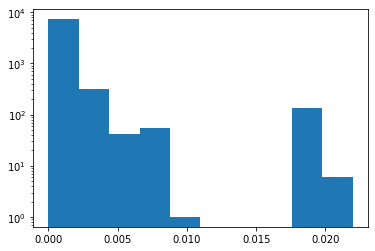

In [20]:
# Calculate the degree centrality using nx.degree_centrality: dcs and plot the graph
dcs = nx.degree_centrality(user_graph)

plt.hist(list(dcs.values()))
plt.yscale('log')  
plt.show()  

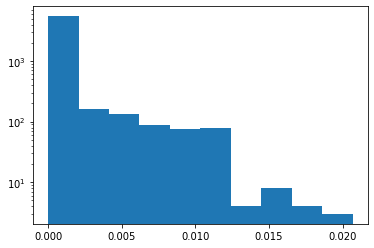

In [21]:
#Do the same
nx.bipartite.degree_centrality(G, recipe_nodes) 

# Create the recipe nodes projection as a graph: G_recipe
G_recipe = nx.bipartite.projected_graph(G, nodes=recipe_nodes)

# Calculate the degree centrality using nx.degree_centrality: dcs
dcs = nx.degree_centrality(G_recipe)
plt.hist(list(dcs.values()))
plt.yscale('log')  
plt.show()


**Betweenness centrality** represents the number of shortest paths through a node divided by all possible shortest paths. It captures bottleneck nodes in a graph rather than highly connected nodes.

In [22]:
print(sorted(nx.betweenness_centrality(user_graph).items(), key=lambda x: x[1], reverse=True)[:2])

[(2123645, 0.004022114401750812), (2002295280, 0.004017610333215215)]
